In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

from core.date_utils import next_date
from core.live_data_processor import LiveDataLoader
from core.model import Model
from core.const import INPUT_TIME_STEP, NUMBER_OF_FEATURE, OUTPUT_TIME_STEP

Using TensorFlow backend.


In [2]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()
    
def plot_results_sequence(today_data, predict_next_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(today_data, label='True Data')
	# Pad the list of predictions to shift it in the graph to it's correct start
    padding = [None for p in range(today_data.size)]
    plt.plot(padding + predict_next_data, label='Prediction')
    plt.legend()
    plt.show()


In [3]:
if __name__ == '__main__':
    data = LiveDataLoader(
        filename=os.path.join('data', 'gld.csv'),
        split=0.8,
        cols=['Open', 'Close', 'Volume']
    )

In [4]:
    model = Model()
    model.load_model('model.h5')
    model.model.summary()

[Model] Loading model from file ./model/model.h5
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 29, 100)           41600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

[Model] Predicting Point-by-Point...


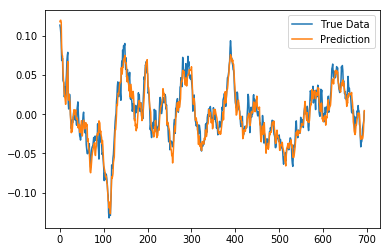

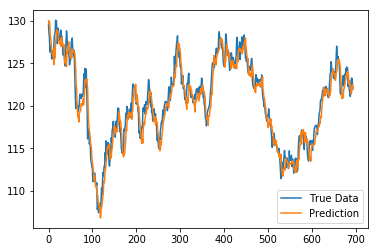

,Date,Prediction,Actual,Prediction Normalise,Actual Normalise
0,2016-07-11,130.003400,129.490005,0.118116,0.113701
1,2016-07-12,129.626539,128.520004,0.119787,0.110228
2,2016-07-13,129.879500,128.000000,0.119940,0.103734
3,2016-07-14,129.347284,126.309998,0.117182,0.090948
4,2016-07-15,128.198177,126.379997,0.084128,0.068753
5,2016-07-18,127.946900,127.019997,0.076179,0.068383
6,2016-07-19,127.289950,126.949997,0.074177,0.071308
7,2016-07-20,126.792289,125.500000,0.053967,0.043225
8,2016-07-21,126.168564,125.660004,0.046087,0.041871
9,2016-07-22,126.033899,126.430000,0.036889,0.040148


[Model] Predicting Point-by-Point...
[Prediction] Next day 2019-04-16 close gold price normalized 0.003665
[Prediction] Next day 2019-04-16 close gold price 121.875069
[Prediction] Correct 62.73 %
[Model] Predicting Next Sequences...


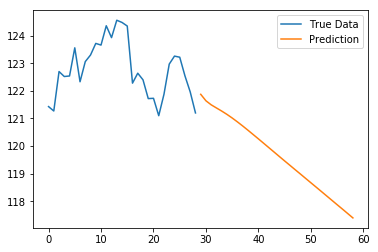

[Prediction] Mean entropy 0.008813
[Prediction] Max deviation 0.048775
[Prediction] Rmse 1.772299


In [5]:
    x_test, y_test = data.get_test_data(
    seq_len=30,
    normalise=True)
    
    y_test = y_test[:, -1]
    
    x_test_normal, y_test_normal = data.get_test_data(
                         seq_len=INPUT_TIME_STEP + 1,
                         normalise=False)
    base_price = x_test_normal[:, -1]
    y_test_normal = y_test_normal[:,-1]
    predictions_p = model.predict_point_by_point(x_test)
    predictions_p_normal = data.denormailise_prediction(INPUT_TIME_STEP + 1, predictions_p)
    
    plot_results(predictions_p, y_test)
    plot_results(predictions_p_normal, y_test_normal)
    result_panel = pd.DataFrame({'Date': data.get_test_date(INPUT_TIME_STEP + 1),
                                 'Prediction':predictions_p_normal, 
                                 'Actual':y_test_normal,
                                 'Prediction Normalise': predictions_p,
                                 'Actual Normalise': y_test})
    display(result_panel.head(10))
    today_input_data = data.get_last_data(INPUT_TIME_STEP, True)
    today_input_data_normal = data.get_last_data(INPUT_TIME_STEP, False)
    today_p = model.predict_point_by_point(today_input_data)
    last_date = data.data_test_date[-1]
    today = next_date(last_date)
    print('[Prediction] Next day %s close gold price normalized %f' % (today, today_p))
    today_p = float(today_input_data_normal[0, 0, 0]) *  (1 + today_p)
    print('[Prediction] Next day %s close gold price %f' % (today, today_p))
    count = 0
    diff=[]
    for i in range(y_test_normal.size):
        prediction = float(predictions_p_normal[i])
        real = float(y_test_normal[i])
        if real != 0 :
            diff.append(abs(prediction / real))
            if abs(1 - abs(prediction / real)) < 0.01 :
                count = count + 1

    diff = np.array(diff)
    # percentage of <5000 difference data in the whole testing data set
    percentage = float(count)/diff.size * 100
    print('[Prediction] Correct %.2f %%' % percentage)
    # display(pd.DataFrame(y_test))
    # display(pd.DataFrame(predictions_p))
    # predicted data that are below 3 difference
    mean_entropy = np.sum(abs(y_test-predictions_p))/len(y_test)

    max_deviation = np.max(abs(y_test-predictions_p))

    deviation = np.array(abs(y_test-predictions_p)).astype(np.float64)
    rmse = np.sqrt(np.sum(predictions_p - y_test)**2)
    
    # Calculate next sequence of gold price
    next_sequence_input_data = data.get_last_data(INPUT_TIME_STEP, True)
    predictions_sequence_p = model.predict_next_sequence(next_sequence_input_data, 30, 30)
    # Denormalize
    next_sequence_input_data = data.get_last_data(INPUT_TIME_STEP, False)
    predictions_sequence_p = [float(next_sequence_input_data[0, 0, 0]) * (1 + p) for p in predictions_sequence_p]
    next_sequence_input_data = next_sequence_input_data[:, :, 0]
    next_sequence_input_data = np.reshape(next_sequence_input_data, [-1, 1])
    plot_results_sequence(next_sequence_input_data, predictions_sequence_p)
    print('[Prediction] Mean entropy %f' % mean_entropy)
    print('[Prediction] Max deviation %f' % max_deviation)
    print('[Prediction] Rmse %f' % rmse)


    